In [1]:
import sys
import os
import shutil
import json
import numpy as np

current_directory = os.getcwd()
path_components = current_directory.split(os.path.sep)
new_directory = os.path.sep.join(path_components[:-1])
sys.path.append(new_directory)

## Post processing framework

#### Simulation Name

In [3]:
simulation_name = 'Main'
simulation_folder = 'tests'

results_dir = os.path.sep.join(path_components[:-2])
results_path = os.path.join(results_dir,'.results',simulation_folder,simulation_name)
results_path = os.path.join(results_dir,'code','results',simulation_name)

main_path = os.path.join(results_dir,'code')
shutil.copyfile(os.path.join(results_path,simulation_name+'.py'), os.path.join(main_path,'S_temp.py'))
print(main_path)
print(results_path)

/home/martinachondo/PINN/code
/home/martinachondo/PINN/code/results/Main


In [4]:
folder_name = 'S_temp'
folder_path = os.path.join(main_path,'results',folder_name)

from S_temp import simulation

simulation.create_simulation()
print(simulation.domain_properties)

/home/martinachondo/PINN/code/Mesh/Mesh_softwares/MSMS/msms -if /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr -of /home/martinachondo/PINN/code/Molecules/Saved_meshes/Temp/born_ion_d10 -p 1.4 -d 10 -no_header
MSMS 2.6.1 started on tulio
Copyright M.F. Sanner (1994)
Compilation flags -O2 -DVERBOSE -DTIMING
Atom 2 ignored, radius = 0.010000
INPUT  /home/martinachondo/PINN/code/Molecules/born_ion/born_ion.xyzr 1 spheres 0 collision only, radii  1.000 to  1.000
PARAM  Probe_radius  1.400 density 10.000 hdensity  3.000
REDUCED SURFACE ...
    1 free vertex (vertices) found
    RS component  #faces  #edges #free_edges  #vertices   genus
         0           0        1          0          1      1
    Time Reduced Surface real: 0.00 user: 0.00 sys: 0.00
ANALYTICAL SOLVENT EXCLUDED SURFACE...
    Component   0
        Time Surface real: 0.00 user: 0.00 sys: 0.00
    SES comp.  #fac.  #edg. #s_edg. #vert. #s_vert. R_h C_h genus
         0        1      0      0       0        0

In [5]:
Iter = 4
simulation.load_model(folder_path,results_path,Iter, save=False)
Post = simulation.Post

OpenMesh not available
No module named 'openmesh'


In [6]:
df = Post.save_values_file(save=False)
print(json.dumps(df, indent=4))

{
    "Gsolv_value": "0.000",
    "L2_continuity_u": "6.561e-01",
    "L2_continuity_du": "1.744e+00",
    "Loss_XPINN": "3.832e+04",
    "Loss_NN1": "3.832e+04",
    "Loss_NN2": "1.865e+04",
    "L2_analytic": "3.429e+02"
}


In [7]:
Post.PDE.get_solvation_energy(Post.XPINN.model)

13677.595229473929

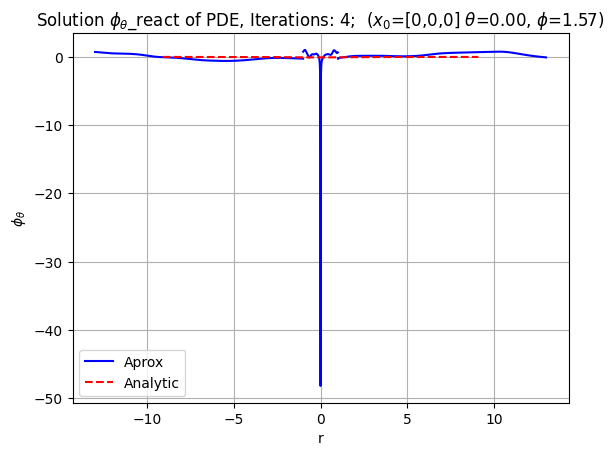

In [8]:
Post.plot_aprox_analytic(value='react')

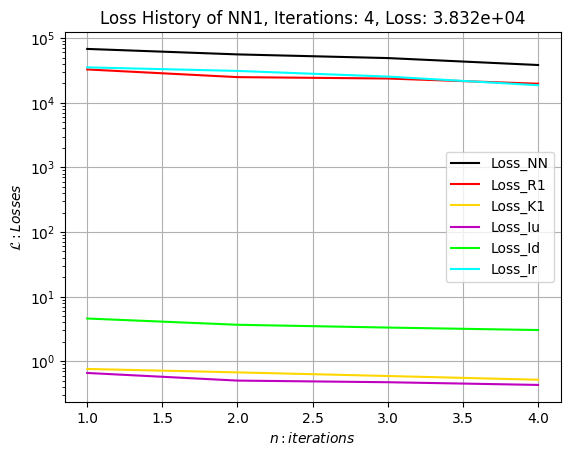

In [9]:
Post.plot_loss_history(domain=1)

#### Computations

In [14]:
import bempp.api

u_interface,_,_ = Post.PDE.get_phi_interface(*Post.NN)
u_interface = u_interface.flatten()
_,du_1,du_2 = Post.PDE.get_dphi_interface(*Post.NN)
du_1 = du_1.flatten()
du_2 = du_2.flatten()
du_1_interface = (du_1+du_2*Post.NN[1].PDE.epsilon/Post.NN[0].PDE.epsilon)/2

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

phi_q = Post.PDE.slp_q * dphi - Post.PDE.dlp_q * phi

slp_aprox = Post.PDE.slp_q * dphi
dlp_aprox = Post.PDE.dlp_q * phi

In [15]:
print('slp',slp_aprox)
print('dlp', dlp_aprox)

slp [[-0.04577357]]
dlp [[-0.00114817]]


In [16]:
Rs = np.linalg.norm(Post.PDE.mesh.mol_verts, axis=1)

u_interface = Post.PDE.analytic_Born_Ion(Rs)
du_1_interface = Post.PDE.analytic_Born_Ion_du(Rs)

phi = bempp.api.GridFunction(Post.PDE.space, coefficients=u_interface)
dphi = bempp.api.GridFunction(Post.PDE.space, coefficients=du_1_interface)

slp_an = Post.PDE.slp_q * dphi
dlp_an = Post.PDE.dlp_q * phi

In [17]:
print('slp',slp_an)
print('dlp', dlp_an)

slp [[-0.07938546]]
dlp [[-0.00094506]]


In [18]:
def get_Gsolv(slp,dlp):
  phi_q = slp - dlp
  G_solv = 0.5*np.sum(Post.PDE.qs * phi_q).real
  G_solv *= Post.PDE.to_V*Post.PDE.qe*Post.PDE.Na*(10**-3/4.184) 
  return G_solv

In [19]:
print('aprox',get_Gsolv(slp_aprox,dlp_aprox))
print('an',get_Gsolv(slp_an,dlp_an))

aprox -93.10722575405698
an -163.65945134158008


In [20]:
print('ap-an',get_Gsolv(slp_aprox,dlp_an))
print('an-ap',get_Gsolv(slp_an,dlp_aprox))

ap-an -93.53099959788352
an-ap -163.23567749775356
